### Приоритезация гипотез

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
from collections import defaultdict

#### Загрузка данных

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net//datasets/hypothesis.csv')


#### Предобработка данных

In [3]:
hypothesis.info()
hypothesis.columns = hypothesis.columns.str.lower() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']


#### Применение фреймворка ICE

In [5]:
hypothesis.sort_values(by='ice', ascending =False)
hypothesis.style.set_properties(**{'text-align': 'left'})

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000


#### Применение фреймворка RICE

In [6]:
hypothesis.sort_values(by='rice', ascending =False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


#### Вывод

По фреймворку ICE приоритет имеют гипотезы 8, 0 , 7.\
По фреймворку RICE приоритет имеют гипотезы 7, 2, 0.\
При фреймворке RICE учитывается охват изменений в отличие от ICE, поэтому приоритетными остаются гипотезы 7, 2 , 0.

### Анализ A/B теста

#### Загрузка данных

In [7]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net//datasets/orders.csv')
    
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net//datasets/visitors.csv')

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


#### Предобработка данных

In [10]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
orders.rename(columns= {'transactionid': 'transaction_id', 'visitorid': 'visitor_id'}, inplace = True)

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [12]:
orders['date'] = orders['date'].astype('datetime64[D]')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(orders['date'].min(), orders['date'].max()))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.head(5)


Начальная дата 2019-08-01, конечная дата 2019-08-31



,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [13]:
visitors['date'] = visitors['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
print('\nНачальная дата {}, конечная дата {}\n'.format(visitors['date'].min(), visitors['date'].max()))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.head(5)


Начальная дата 2019-08-01, конечная дата 2019-08-31



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


#### Проверка на корректность распределения групп

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе B: 18916
Кол-во покупок в группе A: 557
Кол-во покупок в группе B: 640


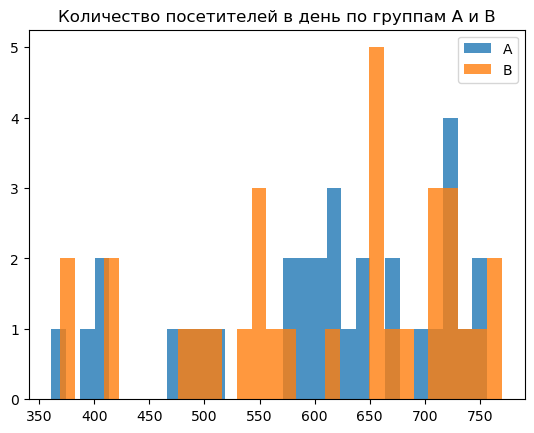

P-value:0.7301376549390499
Разница в количестве посетителей в группах A и B статистически НЕ значима

Начальная конверсия: 0.030
Полученная после изменений конверсия: 0.034
Относительное изменение конверсии после изменений: 0.121


In [14]:
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='A']['visitors'].sum(), 
                                                 visitors[visitors['group']=='B']['visitors'].sum()))
purchasesA = len(orders[orders['group']=='A'])
purchasesB = len(orders[orders['group']=='B'])
print('Кол-во покупок в группе A: {}'.format(purchasesA))
print('Кол-во покупок в группе B: {}'.format(purchasesB))
plt.hist(visitors[visitors['group']=='A']['visitors'], alpha = 0.8, label='A', bins = 30)
plt.hist(visitors[visitors['group']=='B']['visitors'], alpha = 0.8, label='B', bins = 30)
plt.legend()
plt.title('Количество посетителей в день по группам A и B')
plt.show()
results = stats.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

initial_conversion = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum() 
resulting_conversion = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()

print('Начальная конверсия: {:.3f}'.format(initial_conversion))
print('Полученная после изменений конверсия: {:.3f}'.format(resulting_conversion))
print('Относительное изменение конверсии после изменений: {:.3f}'.format(abs(1-(initial_conversion/resulting_conversion))))

Получаем необходимое количество выборки 35855 для корректного проведения тестирования, путем расчета на калькуляторе
В нашем случае количество 37652 посещений
Кол-во выборки для A/B тестирования корректно подобрано, статистически значимой разницыв количестве посещений междуу группами не обнаружено

In [15]:
group_sizes = orders.groupby(['visitor_id', 'group']).size().reset_index().drop_duplicates()
group_sizes.columns = ['visitor_id', 'group', 'count']
group_sizes = group_sizes.query('count > 1').sort_values(by='visitor_id')
group_sizes = group_sizes.drop_duplicates()
group_sizes

,visitor_id,group,count
45,199603092,A,4
58,237748145,A,4
63,249864742,B,3
94,366673373,A,2
104,393266494,B,2
...,...,...,...
1045,4109358064,A,2
1050,4134830387,B,2
1065,4186807279,B,2
1079,4256040402,A,7


In [16]:
test_list = list(zip(group_sizes['visitor_id'], group_sizes['group']))
test_dict = defaultdict(list)
for user, group in test_list:
    test_dict[user].append(group)

bad_users = [user for user in test_dict if len(test_dict[user]) > 1]
bad_orders = orders.query('visitor_id in @bad_users')
bad_orders_group = (bad_orders
                        .groupby(['visitor_id', 'group', 'date'])
                        .agg({'transaction_id': 'nunique', 'revenue': 'sum'})
                   )
bad_orders_group

transaction_id  revenue
visitor_id group date                               
1230306981 A     2019-08-09               3    18440
           B     2019-08-09               2    12840
2038680547 A     2019-08-04               2     4070
                 2019-08-17               1     3470
                 2019-08-22               1      760
                 2019-08-25               1      270
           B     2019-08-04               1     2800
                 2019-08-15               1     1680
                 2019-08-29               1     2420
2378935119 A     2019-08-10               1    58220
                 2019-08-15               1     1650
                 2019-08-17               1      310
                 2019-08-22               1     3390
           B     2019-08-09               1    30649
                 2019-08-10               1     2640
                 2019-08-25               1    21220
                 2019-08-28               2    24860
2458001652 A     2019-08-04               1      340
                 2019-08-06               1     1620
                 2019-08-07               1    17379
                 2019-08-11               1     8280
                 2019-08-22               1     5190
           B     2019-08-05               1     2420
                 2019-08-06               2    14030
                 2019-08-08               1     5227
                 2019-08-09               1     5227
                 2019-08-25               1     2385
4256040402 A     2019-08-01               1     5800
                 2019-08-12               1       50
                 2019-08-17               1     1550
                 2019-08-20               1    17650
                 2019-08-23               1    16950
                 2019-08-27               1     1630
                 2019-08-31               1     5170
           B     2019-08-08               1    58220
                 2019-08-16               1    56650
                 2019-08-18               1    10970
                 2019-08-31               1     1850

Пять пользователей входят и в ту и в ту группу, но мы рассматриваем деление по сессиям на группы, то есть удалять этих пользователей не нужно. Используются разные сессии одного пользователя в двух группах

#### Кумулятивная выручка по группам

In [17]:
datesGroups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(x['date'] >= orders['date'], x['group']==orders['group'])]\
.agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis = 1)
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(x['date'] >= visitors['date'], x['group']==visitors['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)

cummulative_data = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

print('\nПолученная таблица с кумулятивными (накопленными) значениями по дате и группам:'
'\n- кол-во покупок \n- кол-во покупателей \n- выручка \n- кол-во посетителей')

print(cummulative_data.head(5))
print('\nНачальная дата {}, конечная дата {}\n'.format(cummulative_data['date'].min(), cummulative_data['date'].max()))


Полученная таблица с кумулятивными (накопленными) значениями по дате и группам:
- кол-во покупок 
- кол-во покупателей 
- выручка 
- кол-во посетителей
        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845

Начальная дата 2019-08-01 00:00:00, конечная дата 2019-08-31 00:00:00



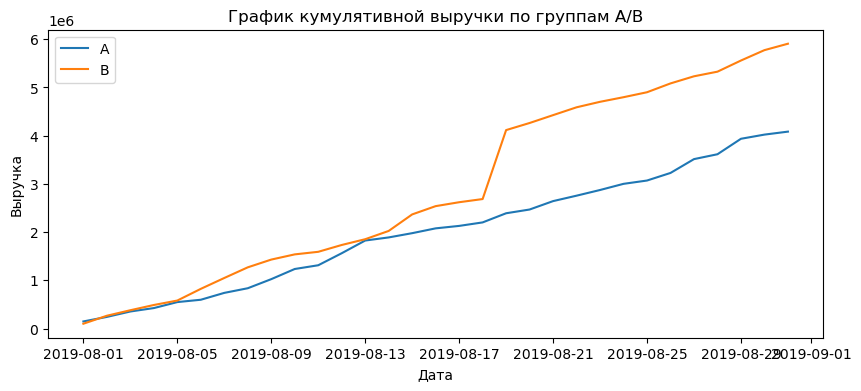

Выводы:
Группа B стабильно показывает большую выручку чем группа A


In [18]:
cummulative_data_A = cummulative_data[cummulative_data['group']=='A']
cummulative_data_B = cummulative_data[cummulative_data['group']=='B']
plt.figure(figsize=(10,4))
plt.plot(cummulative_data_A['date'], cummulative_data_A['revenue'], label = 'A')
plt.plot(cummulative_data_B['date'], cummulative_data_B['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('График кумулятивной выручки по группам A/B')
plt.legend()
plt.show()
print('Выводы:')
print('Группа B стабильно показывает большую выручку чем группа A')

#### Кумулятивный средний чек по группам

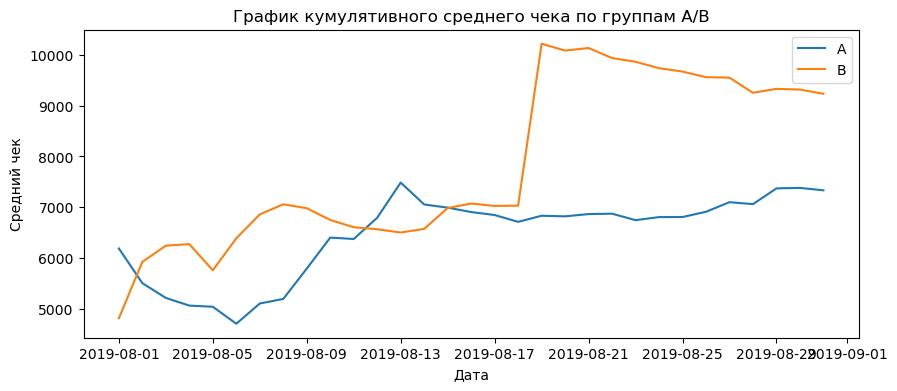

Выводы:
Cредний чек в группе B почти всё время был выше, но вызывает опасения
 его резкое колебание во второй половине графика, есть вероятность, что оно обусловлено аномалиями


In [19]:
plt.figure(figsize=(10,4))
plt.plot(cummulative_data_A['date'], cummulative_data_A['revenue']/cummulative_data_A['orders'], label = 'A')
plt.plot(cummulative_data_B['date'], cummulative_data_B['revenue']/cummulative_data_B['orders'], label = 'B')
plt.title('График кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show()
print('Выводы:')
print('Cредний чек в группе B почти всё время был выше, но вызывает опасения\n '
      'его резкое колебание во второй половине графика, есть вероятность, что оно обусловлено аномалиями')

#### Относительное изменение кумулятивного среднечего чека B к А

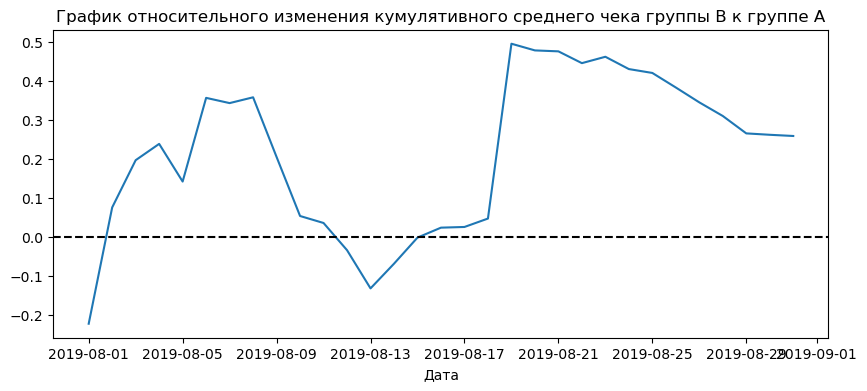

Выводы:
Наблюдаемые колебания слишком резкие, необходимо будет проверить данные на наличие аномальных пользователей


In [20]:
merged_cummulative_data = cummulative_data_A.merge(cummulative_data_B, left_on='date', right_on='date', suffixes=['A', 'B'])
merged_cummulative_data.head(5)
plt.figure(figsize=(10,4))
plt.plot(merged_cummulative_data['date'], ((merged_cummulative_data['revenueB']/merged_cummulative_data['ordersB'])/
                                       (merged_cummulative_data['revenueA']/merged_cummulative_data['ordersA'])-1))
plt.axhline(y=0, color='black', linestyle = '--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.show()
print('Выводы:')
print('Наблюдаемые колебания слишком резкие, необходимо будет проверить данные на наличие аномальных пользователей')

#### Кумулятивное среднее количество заказов на посетителя по группам

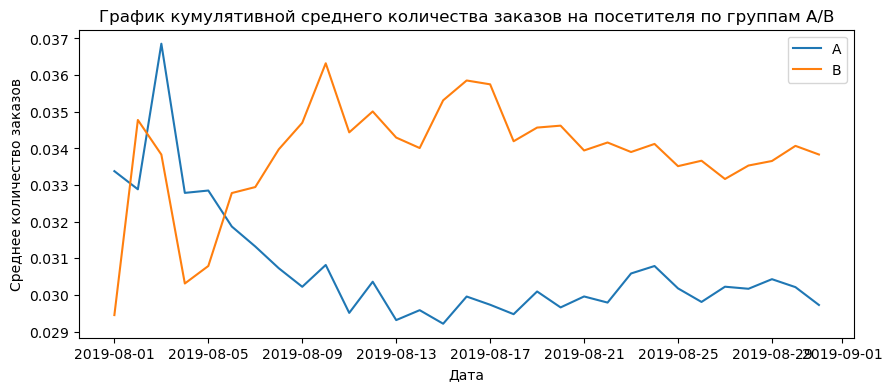

Выводы:
Группа B в начале имеет меньшее среднее количество заказов на посетителя , чем группа А, но по итогу значительно возрастает, а среднее количество заказов на посетителя группы А напротив 
снижается


In [21]:
merged_cummulative_data['conversionA'] =  merged_cummulative_data['ordersA'] / merged_cummulative_data['visitorsA'] 
merged_cummulative_data['conversionB'] =  merged_cummulative_data['ordersB'] / merged_cummulative_data['visitorsB']
merged_cummulative_data.head(5)
plt.figure(figsize=(10,4))
plt.plot(merged_cummulative_data['date'], merged_cummulative_data['conversionA'], label='A')
plt.plot(merged_cummulative_data['date'], merged_cummulative_data['conversionB'], label='B')
plt.title('График кумулятивной среднего количества заказов на посетителя по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.legend()
plt.show()
print('Выводы:')
print('Группа B в начале имеет меньшее среднее количество заказов на посетителя , чем группа А, но по итогу значительно возрастает, а среднее количество заказов на посетителя группы А напротив \nснижается')



#### Относительное изменение кумулятивной конверсии B к А

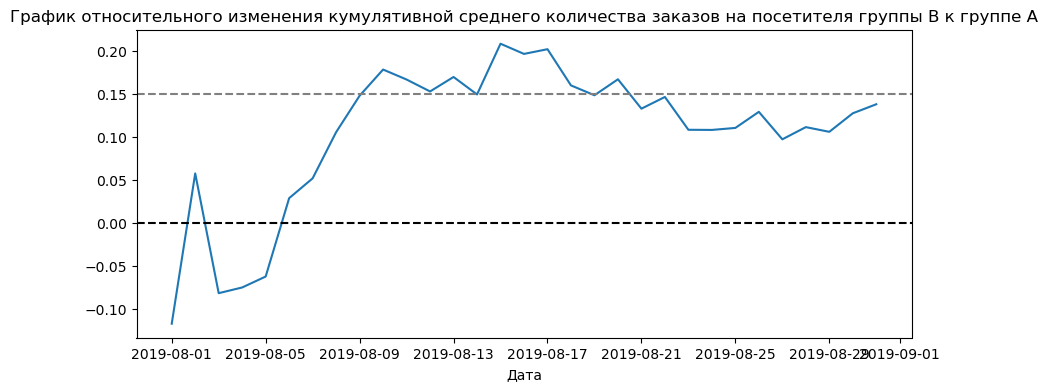

Выводы:
Среднее количество заказов на посетителя в группе B стабильно выше среднего количества заказов на посетителя в группе A более чем на 10% по просшествии 1 недели после начала


In [22]:
merged_cummulative_data.head(5)
plt.figure(figsize=(10,4))
plt.plot(merged_cummulative_data['date'], ((merged_cummulative_data['conversionB']/merged_cummulative_data['conversionA'])-1))
plt.title('График относительного изменения кумулятивной среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.show()
print('Выводы:')
print('Среднее количество заказов на посетителя в группе B стабильно выше среднего количества заказов на посетителя в группе A более чем на 10% по просшествии 1 недели после начала')

#### Распределение числа заказов на одного пользователя

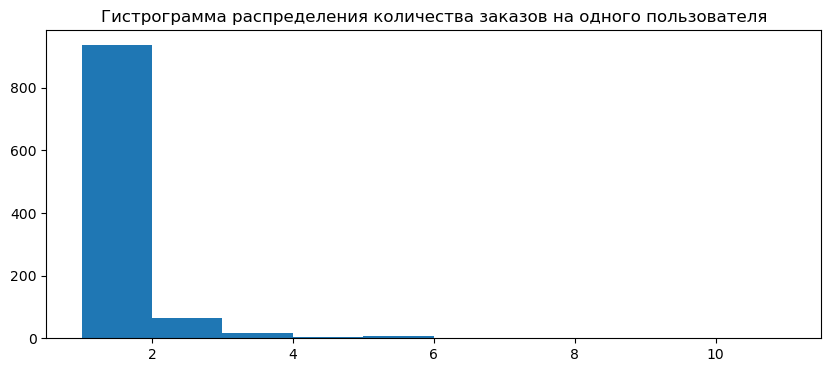

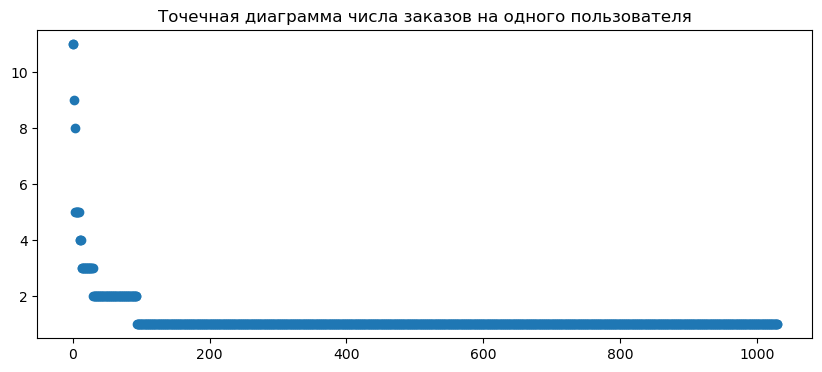

Выводы:
Большинство пользователей не совершает более 2 заказов


In [23]:
orders.head(5)
orders_by_users = orders.groupby('visitor_id', as_index = False).agg({'transaction_id':'nunique'}).sort_values(by='transaction_id', ascending = False)
orders_by_users.columns = ['visitor_id', 'orders']
orders_by_users.head(5)
plt.figure(figsize=(10,4))
plt.hist(orders_by_users['orders'], bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.show()
x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()
print('Выводы:')
print('Большинство пользователей не совершает более 2 заказов')

#### Определение границы количества заказов для аномальных пользователей

In [24]:
percentiles_count = np.percentile(orders_by_users['orders'], [95, 99])
print('Перцентили:\n95: {}\n99: {}'.format(percentiles_count[0],percentiles_count[1]))
print('\nВыводы:')
print('Больше 2 заказов совершают только 5% пользователей, установим лимит в 2 заказа')

Перцентили:
95: 2.0
99: 4.0

Выводы:
Больше 2 заказов совершают только 5% пользователей, установим лимит в 2 заказа


#### Распределение суммы заказа на одного пользователя

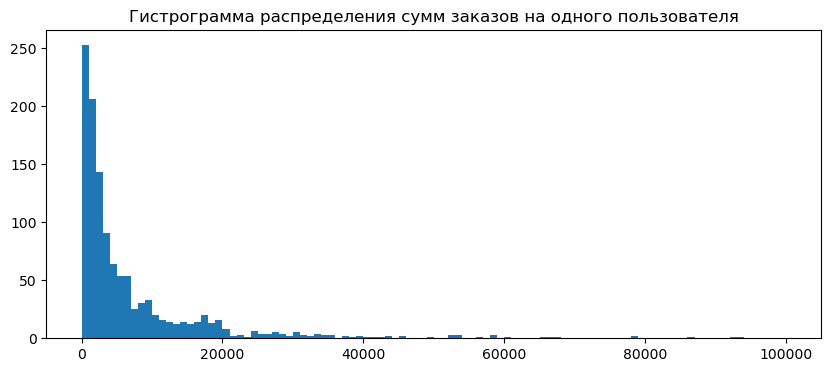

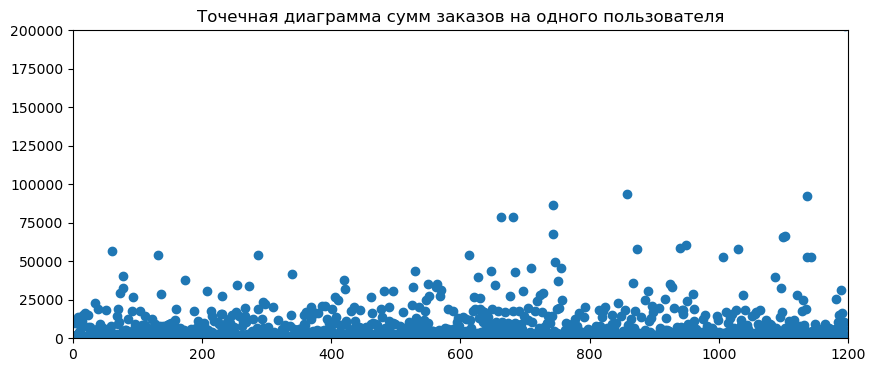

Выводы:
Основная часть покупателей совершают покупки до 25 тыс. рублей. Проверим это далее.


In [25]:
plt.figure(figsize=(10,4))
plt.hist(orders['revenue'], range=(0,100000), bins = 100)
plt.title('Гистрограмма распределения сумм заказов на одного пользователя')
plt.show()
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1200, 0, 200000])
plt.show()
print('Выводы:')
print('Основная часть покупателей совершают покупки до 25 тыс. рублей. Проверим это далее.')

#### Определение границы суммы заказа для аномальных пользователей

In [26]:
percentiles_sum = np.percentile(orders['revenue'], [95, 99])
print('Перцентили:\n95: {:.0f}\n99: {:.0f}'.format(percentiles_sum[0],percentiles_sum[1]))
print('\nВыводы:')
print('Всего лишь 5% заказов дороже 28 тыс.рублей, установим эту цифру как границу')

Перцентили:
95: 28000
99: 58233

Выводы:
Всего лишь 5% заказов дороже 28 тыс.рублей, установим эту цифру как границу


#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами

Используется непараметрический тест Уилкоксона-Манна-Уитни, так как он не подвержен влиянию аномальных значений\
Альфа: 0.05\
Нулевая гипотеза: статистически значимых различий  в среднем количестве заказов на посетителя в группах А и В по 'сырым' данным нет\
Альтернативная гипотеза:  статистически значимые различия в среднем количестве заказов на посетителя в группах А и В по 'сырым' данным есть

In [27]:
orders_by_users_A = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_A.columns = ['visitor_id', 'orders']
orders_by_users_B = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_B.columns = ['visitor_id', 'orders']
print('Кол-во покупателей в группе A: {}'.format(len(orders_by_users_A)))
print('Кол-во покупок в группе А: {}'.format(orders_by_users_A['orders'].sum()))
print('Кол-во посетителей в группе A: {}\n'.format(visitors[visitors['group']=='A']['visitors'].sum()))
print('Кол-во покупателей в группе B: {}'.format(len(orders_by_users_B)))
print('Кол-во покупок в группе B: {}'.format(orders_by_users_B['orders'].sum()))
print('Кол-во посетителей в группе B: {}'.format(visitors[visitors['group']=='B']['visitors'].sum()))

list_orders_1 =[]
for i in range(0,(visitors[visitors['group']=='A']['visitors'].sum()-len(orders_by_users_A))):
    list_orders_1.append(0)
orders_by_non_purchased_users_A = pd.Series(data = list_orders_1, name = 'orders')

list_orders_2 =[]
for i in range(0,(visitors[visitors['group']=='B']['visitors'].sum()-len(orders_by_users_B))):
    list_orders_2.append(0)
orders_by_non_purchased_users_B = pd.Series(data = list_orders_2, name = 'orders')

sample_A = pd.concat([orders_by_users_A['orders'], orders_by_non_purchased_users_A], axis=0)
sample_B = pd.concat([orders_by_users_B['orders'], orders_by_non_purchased_users_B], axis=0)
print('\nОтносительный прирост среднего количества заказов на пользователя группы B по отношению к группе A: {:.3f}'.format(sample_B.mean()/sample_A.mean()-1))
alpha = 0.05
results = stats.mannwhitneyu(sample_A, sample_B)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

Кол-во покупателей в группе A: 503
Кол-во покупок в группе А: 557
Кол-во посетителей в группе A: 18736

Кол-во покупателей в группе B: 586
Кол-во покупок в группе B: 640
Кол-во посетителей в группе B: 18916

Относительный прирост среднего количества заказов на пользователя группы B по отношению к группе A: 0.138
P-value: 0.016792355056752608
Отвергаем нулевую гипотезу


#### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

Используется непараметрический тест Уилкоксона-Манна-Уитни\
Альфа: 0.05\
Нулевая гипотеза: статистически значимых различий в среднем чеке заказа в группах А и В по 'сырым' данным нет\
Альтернативная гипотеза: статистически значимые различия в среднем чеке заказа в группах А и В по 'сырым' данным есть

In [28]:
print('Относительное изменение среднего чека в группе B по отношению группы A: {:.3f}'.format(
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

Относительное изменение среднего чека в группе B по отношению группы A: 0.259
P-value: 0.7292909855432458
Принимаем нулевую гипотезу


#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [29]:
limit_orders = percentiles_count[0]
limit_revenue = percentiles_sum[0]
users_with_many_orders = pd.concat([orders_by_users_A[orders_by_users_A['orders']>limit_orders]['visitor_id'], 
                                orders_by_users_B[orders_by_users_B['orders']>limit_orders]['visitor_id']], axis = 0)
users_with_expensive_orders = orders[orders['revenue']>limit_revenue]['visitor_id']
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis = 0).drop_duplicates().sort_values()
print('Кол-во аномальных пользователей: {}'.format(len(abnormal_users)))

Кол-во аномальных пользователей: 74


Используется непараметрический тест Уилкоксона-Манна-Уитни\
Альфа: 0.05\
Нулевая гипотеза: статистически значимых различий в среднем количестве заказов на посетителя в группах А и В по 'очищенным' данным нет\
Альтернативная гипотеза: статистически значимые различия в среднем количестве заказов на посетителя  в группах А и В по 'очищенным' данным есть

In [30]:
sample_A_filtered = pd.concat([
    orders_by_users_A[np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))]['orders'],
    orders_by_non_purchased_users_A
], axis = 0)
sample_B_filtered = pd.concat([
    orders_by_users_B[np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))]['orders'],
    orders_by_non_purchased_users_B
], axis = 0)
print('\nОтносительный прирост среднего количества заказов на посетителя группы B по отношению к группе A после очистки данных: {:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))
results = stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')


Относительный прирост среднего количества заказов на посетителя группы B по отношению к группе A после очистки данных: 0.173
P-value: 0.013042592743036745
Отвергаем нулевую гипотезу


#### Расчет статистической значимости различий в среднем чеке между группами по "очищенным" данным

Используется непараметрический тест Уилкоксона-Манна-Уитни\
Альфа: 0.05\
Нулевая гипотеза: статистически значимых различий в среднем чеке заказа в группах А и В по 'очищенным' данным нет\
Альтернативная гипотеза: статистически значимые различия в среднем чеке заказа в группах А и В по 'очищенным' данным есть

In [31]:
print('Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()-1))
       
       
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])
print('P-value: {}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отваргем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу')

Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.020
P-value: 0.738481751314565
Принимаем нулевую гипотезу


### Вывод

Группы имеют корректный размер, проблема подглядывания в результате сравнения групп во время проведения теста была исключена.\
По всем кумулятивным метрикам лидерство было у группы В, хотя на графике кумулятивного среднего чека у группы В наблюдялись сильные колебания, что свидетельствует о наличие аномалий.\
После нахождения границ аномалий и коррекции области данных по количеству заказов и суммы заказа разница по среднему чеку изменилась и стала минимальна\
Но при этом показатель конверсии группы В даже по очищенным данным превышает конверсию группы А на 17% ( с 14 до 17%)\
Такой показатель разницы конверсий является статистически значимым, что позволяет зафиксировать победу групыы В и остановить тест.
